# Knockout Analysis and Survivability


In [2]:
from common_variables import *
DATA['paths']

Data loading complete!
Data loaded into DATA dictionary.


{'base_dir': '/Users/handan/Documents/CSBL/project-files/tme-network-topology',
 'dir_binary_rxns': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/binaryRxnsTable.csv',
 'dir_binary_mets': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/binaryMetsTable.csv',
 'dir_binary_genes': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/binaryGenesTable.csv',
 'dir_umap_data': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/r/output/umap_pos_data.csv',
 'dir_samples': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/samples',
 'dir_nodesedges': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/graphs',
 'dir_simulations': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/simulations',
 'dir_survival_data': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/r/output_data'}

In [3]:
# Read the knockout MOMA results
knockoutRatios = pd.read_csv(os.path.join(DATA['paths']['dir_simulations'],  'singleGene_knockoutRatios_MOMA.csv'))
knockoutGrowths = pd.read_csv(os.path.join(DATA['paths']['dir_simulations'], 'singleGene_knockoutGrowth_MOMA.csv'))

# # Keep it only to Malingnant, FAP+ and MARCO+
# knockoutRatios = knockoutRatios.filter(regex='Genes|GeneShortNames|UsedReactions|Malignant|FAP+|MARCO+')
# knockoutGrowths = knockoutGrowths.filter(regex='Genes|GeneShortNames|UsedReactions|Malignant|FAP+|MARCO+')


# Identify numeric columns in knockoutRatios automatically
numeric_cols = knockoutRatios.select_dtypes(include=[np.number]).columns.tolist()

# If all rows are 1 in numeric_cols, remove those rows
knockoutRatios = knockoutRatios.loc[(knockoutRatios[numeric_cols] != 1).any(axis=1)]
knockoutRatios = knockoutRatios.loc[(knockoutRatios[numeric_cols] != 0).any(axis=1)]

In [4]:
def analyzeKnockouts(knockout_df, binary_rxns_df, kill_threshold=0.5, safe_threshold=0.5):
    
    df = knockout_df.copy()

    # Define column groups
    non_numeric_cols = ['Genes', 'GeneShortNames', 'UsedReactions']
    all_numeric_cols = [col for col in df.columns if col not in non_numeric_cols]
    tumor_cols = [col for col in all_numeric_cols if 'Tumor' in col]
    normal_cols = [col for col in all_numeric_cols if 'Normal' in col]

    # Calculate means
    df['tumor_mean'] = df[tumor_cols].mean(axis=1)
    df['normal_mean'] = df[normal_cols].mean(axis=1)

    # Filter by thresholds
    df = df[(df['tumor_mean'] <= kill_threshold) & (df['normal_mean'] >= safe_threshold)].copy()
    print(f"Filtered genes: {len(df)} remaining after thresholds.")

    # Calculate pathway scores
    pathway_importance = getPathwayImportanceOrdering()
    df = df.copy()
    df['reaction_list'] = df['UsedReactions'].apply(lambda x: x.split(',') if pd.notna(x) else [])
    df['pathway_score'] = 0
    df['dominant_pathway'] = '' 
    
    for idx, row in df.iterrows():
        reactions = [r.strip() for r in row['reaction_list']]
        scores, counts = [], {}
        
        for reaction in reactions:
            match = binary_rxns_df[binary_rxns_df['Reactions'] == reaction]
            if not match.empty:
                subsystem = match.iloc[0]['subSystems']
                importance = pathway_importance[subsystem.lower()]
                scores.append(importance)
                counts[subsystem] = counts.get(subsystem, 0) + 1
        if scores:
            df.at[idx, 'dominant_pathway'] = max(counts, key=counts.get, default='unknown')
            df.at[idx, 'pathway_score'] = pathway_importance[df.at[idx, 'dominant_pathway']]

    # Sort by pathway importance first, then by tumor_mean (lower is better)
    top_targets = df.sort_values(['pathway_score', 'tumor_mean'], ascending=[False, True])
    
    # Group genes by dominant pathway
    pathway_groups = {}
    for _, row in top_targets.iterrows():
        pathway = row['dominant_pathway'] if pd.notna(row['dominant_pathway']) else 'unknown'
        if pathway not in pathway_groups:
            pathway_groups[pathway] = []
        pathway_groups[pathway].append(row)

    # Sort pathways by importance
    def get_pathway_importance(pathway):
        return pathway_importance.get(pathway.lower(), 1)

    sorted_pathways = sorted(pathway_groups.keys(), key=get_pathway_importance, reverse=True)

    # Reorganize top_targets to group by pathway
    grouped_targets = []
    for pathway in sorted_pathways:
        # Sort genes within each pathway by tumor_mean (lower = more effective)
        pathway_genes = sorted(pathway_groups[pathway], key=lambda x: x['tumor_mean'])
        grouped_targets.extend(pathway_genes)

    # Convert back to DataFrame
    top_targets = pd.DataFrame(grouped_targets)

    if len(top_targets) == 0:
        print("No genes found matching the criteria!")
        return 

    return {
        'top_targets': top_targets,
        'total_targets': len(top_targets),
        'df_with_pathways': df,
        'pathway_groups': pathway_groups,
        'sorted_pathways': sorted_pathways
    }

knockoutTargets = analyzeKnockouts(knockoutRatios, DATA['binary_rxns'], kill_threshold=0.4, safe_threshold=0.6)



Filtered genes: 19 remaining after thresholds.


##### **(A)** Scatter plot showing the relationship between mean cell viability in tumor versus normal tissues for all knockout targets. Points in the target region (blue shaded area) represent genes with selective toxicity to tumor cells while sparing normal cells.

Figure saved: figure2a_gene_knockout_scatter


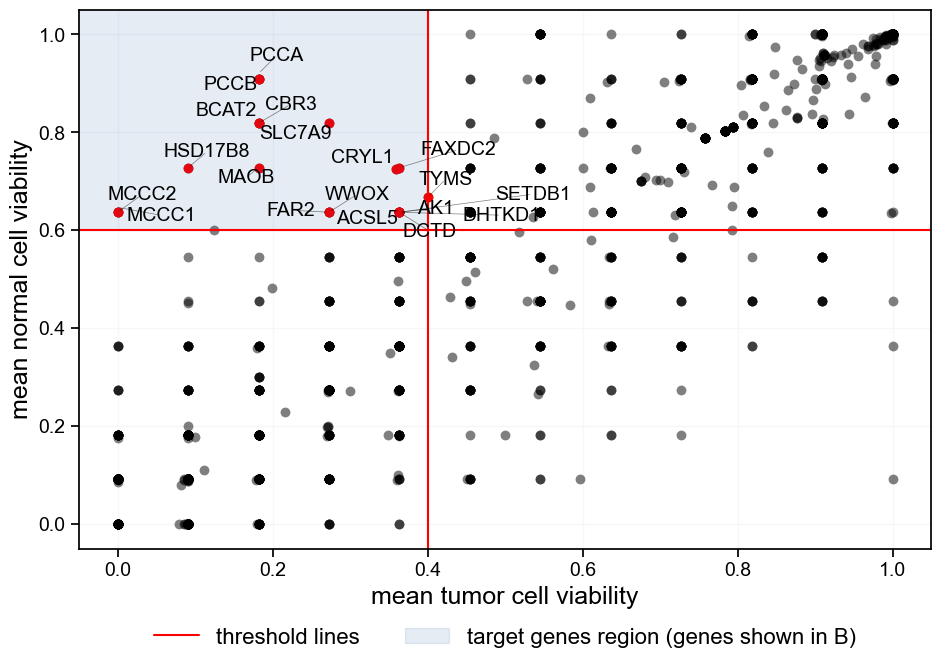

In [109]:
def allGenesScatterPlot(knockoutRatios, highlightTargets, tumor_threshold_line=0.4, normal_threshold_line=0.6, figsize=(8, 6)):

    # Prepare the full dataset
    all_genes_df = knockoutRatios.copy()

    # Define tumor/normal columns
    non_numeric_cols = ['Genes', 'GeneShortNames', 'UsedReactions']
    all_numeric_cols = [col for col in all_genes_df.columns if col not in non_numeric_cols]
    tumor_cols = [col for col in all_numeric_cols if 'Tumor' in col]
    normal_cols = [col for col in all_numeric_cols if 'Normal' in col]

    # Calculate mean expression
    all_genes_df['tumor_mean'] = all_genes_df[tumor_cols].mean(axis=1)
    all_genes_df['normal_mean'] = all_genes_df[normal_cols].mean(axis=1)


    # Create figure
    fig = plt.figure(figsize=figsize)
    plt.scatter(all_genes_df['tumor_mean'], all_genes_df['normal_mean'], c='black', alpha=0.5, s=50, linewidth=0)
    plt.scatter(highlightTargets['tumor_mean'], highlightTargets['normal_mean'], c='red', alpha=1, s=50, linewidth=0)
     
    # Annotation positioning to handle overlapping genes
    from adjustText import adjust_text

    # Simple annotation with automatic adjustment
    texts = []
    for i, row in highlightTargets.iterrows():
            x, y = row['tumor_mean'], row['normal_mean']
            label = row['GeneShortNames']
            if label == 'MCCC1': x, y = row['tumor_mean'], row['normal_mean']+0.01  # Nudge MCCC1 label up slightly
            if label == 'PCCA': x, y = row['tumor_mean'], row['normal_mean']+0.01  # Nudge PCCA label up slightly
            text = plt.text(x, y, label, 
                        fontsize=14, 
                        ha='right', 
                        va='top',
                        color='black')
            texts.append(text)

    # Automatically adjust text positions to avoid overlap
    adjust_text(texts, 
            arrowprops=dict(arrowstyle='-', color='black', lw=0.5, alpha=0.5),
            expand_points=(.7, .7),  # Space around points
            expand_text=(.7, .7),    # Space around text
            force_text=(.2, .2),     # Repulsion between labels
            force_points=(.5, .5))   # Attraction to original points
    
    # Add threshold regions
    plt.axvline(x=tumor_threshold_line, color='red', linestyle='-', linewidth=1.5, alpha=1, label="threshold lines")
    plt.axhline(y=normal_threshold_line, color='red', linestyle='-', linewidth=1.5, alpha=1)
    
    # Highlight the "optimal" region
    rect = Rectangle((-.1, normal_threshold_line), tumor_threshold_line+0.1, plt.ylim()[1]-0.5,  linewidth=1, edgecolor='#00469c', facecolor="#00469c", alpha=0.1, label='target genes region (genes shown in B)')
    plt.gca().add_patch(rect)
    
    plt.xlabel('mean tumor cell viability')
    plt.ylabel('mean normal cell viability')
    plt.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5, -0.22), ncol=2, fontsize=16)
    plt.grid(True)

    save_figure(fig, 'figure2a_gene_knockout_scatter')
    
    plt.show()


    return fig


# You can specify how many top genes to highlight (optional)
fig2a = allGenesScatterPlot(knockoutRatios, knockoutTargets['top_targets'], tumor_threshold_line=0.4, normal_threshold_line=0.6, figsize=(11, 7))


##### **(B)** Heatmap showing knockout ratios for candidate metabolic targets across tumor-associated cell populations (malignant epithelial cells, FAP+ fibroblasts, MARCO+ macrophages) and their normal tissue counterparts. Blue intensity indicates essentiality (knockout ratio = 1.0 = dark blue represents complete lethality). Genes are grouped by metabolic pathway annotations.

Figure saved: figure2b_target_genes_heatmap


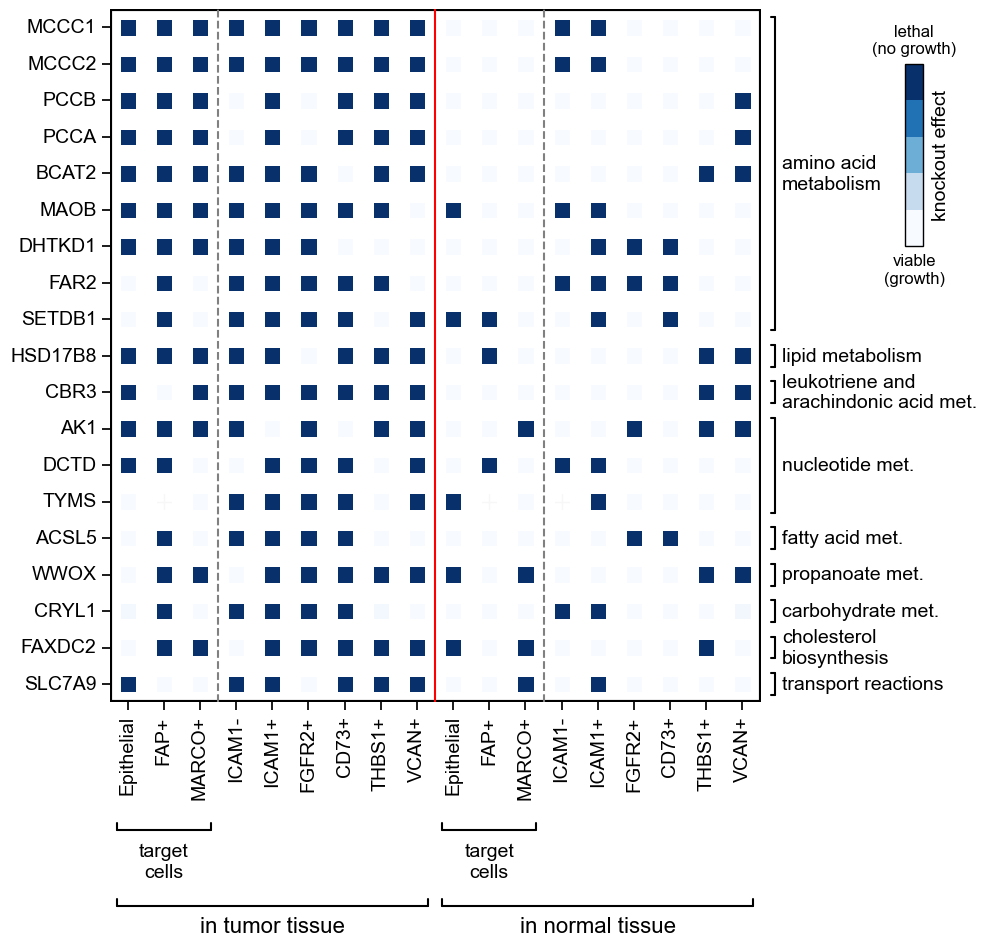

In [101]:
def knockoutTargetsHeatmap(knockoutTargets, binary_rxns_df, base_figsize=(12, 10), height_per_gene=0.3, highlight_genes=None):
    
    def get_importance(subsystem):
        pathway_ordering = getPathwayImportanceOrdering()
        if pd.isna(subsystem): return 0
        sub_lower = subsystem.lower()
        return pathway_ordering.get(sub_lower, next((score for key, score in pathway_ordering.items() if key in sub_lower), -1))

    df = knockoutTargets.copy()
    
    # Calculate pathway scores
    df['reaction_list'] = df['UsedReactions'].apply(lambda x: x.split(',') if pd.notna(x) else [])
    df['pathway_score'] = 0
    df['dominant_pathway'] = ''
    
    for idx, row in df.iterrows():
        reactions = [r.strip() for r in row['reaction_list']]
        counts = {}
        for reaction in reactions:
            match = binary_rxns_df[binary_rxns_df['Reactions'] == reaction]
            if not match.empty:
                subsystem = match.iloc[0]['subSystems']
                counts[subsystem] = counts.get(subsystem, 0) + 1
        if counts: 
            df.at[idx, 'dominant_pathway'] = max(counts, key=counts.get)
            df.at[idx, 'pathway_score'] = get_importance(df.at[idx, 'dominant_pathway'])

    # Calulate mean in the columns for ordering
    main_targets = ['Cancer_Tumor_Malignant', 'Fibroblast_Tumor_FAP+', 'Macrophage_Tumor_MARCO+']
    df['main_targets_mean'] = df[main_targets].mean(axis=1)

    # Sort and group by pathway
    grouped = []
    for pathway in sorted(df['dominant_pathway'].unique(), 
                         key=lambda p: get_importance(p), reverse=True):
        
        pathway_genes = df[df['dominant_pathway'] == pathway].sort_values(['pathway_score', 'main_targets_mean', 'tumor_mean', 'normal_mean'], ascending=[False, True, True, False])
        grouped.extend(pathway_genes.to_dict('records'))
    
    top_targets = pd.DataFrame(grouped)
    orderedEnsemblIDs = top_targets['Genes'].tolist()
    
    # Setup visualization
    fig_height = max(base_figsize[1], len(top_targets) * height_per_gene)
    fig = plt.figure(figsize=(base_figsize[0], fig_height))
    
    # Column setup
    column_order = ['Cancer_Tumor_Malignant', 'Fibroblast_Tumor_FAP+', 'Macrophage_Tumor_MARCO+', # top targets
                     'Fibroblast_Tumor_ICAM1-', 'Fibroblast_Tumor_ICAM1+', 'Fibroblast_Tumor_FGFR2+', # tumor
                     'Fibroblast_Tumor_CD73+', 'Macrophage_Tumor_THBS1+', 'Macrophage_Tumor_VCAN+',
                     'Cancer_Normal_Malignant', 'Fibroblast_Normal_FAP+', 'Macrophage_Normal_MARCO+',  # normal
                     'Fibroblast_Normal_ICAM1-', 'Fibroblast_Normal_ICAM1+', 'Fibroblast_Normal_FGFR2+',
                     'Fibroblast_Normal_CD73+', 'Macrophage_Normal_THBS1+', 'Macrophage_Normal_VCAN+']
    
    non_numeric = ['Genes', 'GeneShortNames', 'UsedReactions']
    all_numeric = [c for c in df.columns if c not in non_numeric]
    vis_cols = [c for c in column_order if c in all_numeric]
    
    # Create heatmap
    heatmap_data = top_targets[vis_cols].copy()
    heatmap_data.columns = ['_'.join(c.split('_')[2:]).replace('Malignant', 'Epithelial') 
                            for c in vis_cols]
    # #heatmap_data.index = top_targets['GeneShortNames']
    # # heatmap_data.index = top_targets['Genes'] + ': ' + top_targets['GeneShortNames']
    
    # # ax = sns.heatmap(heatmap_data, cmap='Blues_r', square=True, linewidths=12,  linecolor='white', cbar=False, )
    # # ax.set_ylabel('')

   # Assuming heatmap_data and top_targets are defined as before
    heatmap_data.index = top_targets['Genes'] + ': ' + top_targets['GeneShortNames']

    ax = sns.heatmap(heatmap_data, cmap='Blues_r', square=False, linewidths=14, linecolor='white', cbar=False)

    ax.set_ylabel('')
    # Remove default yticklabels
    ax.set_yticklabels([''] * len(heatmap_data.index))

    yticks = ax.get_yticks()
    for ytick, index in zip(yticks, heatmap_data.index):
        gene, short_name = index.split(': ')
        full_label = f"{gene} {short_name}"
        # First draw the whole label in gray
        #ax.text(-0.02, ytick, full_label, color='black', alpha=0.2,va='center', ha='right', fontsize=14, transform=ax.get_yaxis_transform())
        # Then draw the short name in black, slightly offset to overlay just that part
        ax.text(-0.02, ytick, short_name, color='black', va='center', ha='right', fontsize=14, transform=ax.get_yaxis_transform())



    for _, spine in ax.spines.items():
        spine.set_visible(False)    
    # Add pathway brackets and labels
    pathway_positions = {}
    for i, pathway in enumerate(top_targets['dominant_pathway']):
        pathway = pathway if pd.notna(pathway) else 'unknown'
        if pathway not in pathway_positions:
            pathway_positions[pathway] = [i, i]
        pathway_positions[pathway][1] = i
    
    for pathway, (start, end) in pathway_positions.items():
        line_x = len(vis_cols) + 0.4
        
        bracket = [[line_x - 0.1, start + 0.2], [line_x, start + 0.2],
                  [line_x, end + 0.8], [line_x - 0.1, end + 0.8]]
        for i in range(len(bracket) - 1):
            ax.plot([bracket[i][0], bracket[i+1][0]], [bracket[i][1], bracket[i+1][1]],
                   color='black', linewidth=1.5, clip_on=False)
        
        # Shorten long pathway names
        label = pathway
        label = label[:label.find('met') + 3]+'.' if 'metabolism' in label else label
        if 'amino acid' in label: label = 'amino acid\nmetabolism'
        elif 'leukotriene' in label: label = 'leukotriene and\narachindonic acid met.'
        elif 'nicotinate' in label: label = 'nicotinate and nicotinamide met.'
        elif 'cholesterol' in label: label = 'cholesterol\nbiosynthesis'
        elif 'lipid' in label: label = 'lipid metabolism'
        
        ax.text(line_x + 0.2, (start + end) / 2 + 0.5, label, ha='left', va='center', fontsize=14)
    
    # Highlight genes if specified
    if highlight_genes:
        highlight_genes = [highlight_genes] if isinstance(highlight_genes, str) else highlight_genes
        for i, label in enumerate(ax.get_yticklabels()):
            if (top_targets['Genes'].iloc[i] in highlight_genes or 
                top_targets['GeneShortNames'].iloc[i] in highlight_genes):
                label.set_color('red')
    
    # Add borders and dividers
    ax.add_patch(plt.Rectangle((0, 0), len(vis_cols), len(top_targets), fill=False, edgecolor='black', lw=3))
    ax.axvline(len(vis_cols), color='black', linestyle='-', linewidth=1)
    
    tumor_count = sum('Tumor' in c for c in vis_cols)
    ax.axvline(tumor_count, color='red', linewidth=1.5)
    ax.axvline(tumor_count/3, color='grey', linestyle='--', linewidth=1.5)
    ax.axvline(tumor_count+3, color='grey', linestyle='--', linewidth=1.5)

    
    # Add section labels
    y_pos = 22.5
    plt.text(1.5, y_pos+1.3, 'target\ncells', ha='center', fontsize=14)
    line_y = y_pos
    bracket =  [[0.2, line_y - 0.2],
                [0.2, line_y],
                [2.8, line_y],
                [2.8, line_y - 0.2]]
    for i in range(len(bracket) - 1):
        ax.plot([bracket[i][0], bracket[i+1][0]], [bracket[i][1], bracket[i+1][1]],
                color='black', linewidth=1.5, clip_on=False)


    y_pos = 22.5
    plt.text(10.5, y_pos+1.3, 'target\ncells', ha='center', fontsize=14)
    line_y = y_pos
    bracket =  [[9.2, line_y - 0.2],
                [9.2, line_y],
                [11.8, line_y],
                [11.8, line_y - 0.2]]
    for i in range(len(bracket) - 1):
        ax.plot([bracket[i][0], bracket[i+1][0]], [bracket[i][1], bracket[i+1][1]],
                color='black', linewidth=1.5, clip_on=False)
        

    y_pos = 25.3
    plt.text(tumor_count/2, y_pos, 'in tumor tissue', ha='center', fontsize=16)
    line_y = y_pos-0.7
    bracket =  [[0.2, line_y - 0.2],
                [0.2, line_y],
                [8.8, line_y],
                [8.8, line_y - 0.2]]
    for i in range(len(bracket) - 1):
        ax.plot([bracket[i][0], bracket[i+1][0]], [bracket[i][1], bracket[i+1][1]],
                color='black', linewidth=1.5, clip_on=False)
        
    normal_count = sum('Normal' in c for c in vis_cols)
    plt.text(tumor_count + normal_count/2, y_pos, 'in normal tissue', ha='center', fontsize=16)
    line_y = y_pos-0.7
    bracket =  [[9.2, line_y - 0.2],
                [9.2, line_y],
                [17.8, line_y],
                [17.8, line_y - 0.2]]
    for i in range(len(bracket) - 1):
        ax.plot([bracket[i][0], bracket[i+1][0]], [bracket[i][1], bracket[i+1][1]],
                color='black', linewidth=1.5, clip_on=False)

            

    
    plt.xticks(rotation=90, ha='center', fontsize=14)
    plt.yticks(fontsize=16)

    # Add colorbar legend 
    cbar_x = len(vis_cols) + 4  # Adjust this for horizontal position
    cbar_y = 1.5  # Adjust this for vertical position
    cbar_width = .5
    cbar_height = 5

    # Create gradient patches
    n_colors = 5
    colors = plt.cm.Blues_r(np.linspace(0, 1, n_colors))
    for i in range(n_colors):
        rect = Rectangle((cbar_x, cbar_y + i * cbar_height / n_colors), cbar_width, cbar_height / n_colors,facecolor=colors[i], edgecolor='none')
        ax.add_patch(rect)
        rect.set_clip_on(False)

    # Add border around colorbar
    border = Rectangle((cbar_x, cbar_y), cbar_width, cbar_height, fill=False, edgecolor='black', linewidth=1)
    ax.add_patch(border)
    border.set_clip_on(False)

    # Add labels
    ax.text(cbar_x + cbar_width/2, cbar_y + cbar_height + 0.2, 'viable\n(growth)', 
            va='top', ha='center', clip_on=False, fontsize=12)
    ax.text(cbar_x + cbar_width/2, cbar_y - 0.2, 'lethal\n(no growth)', 
            va='bottom', ha='center', clip_on=False, fontsize=12)
    ax.text(cbar_x + 1, cbar_y + cbar_height/2, 'knockout effect', 
            va='center', ha='center', rotation=90, clip_on=False, fontsize=14)


    save_figure(fig, 'figure2b_target_genes_heatmap')

    plt.show()
    return fig, orderedEnsemblIDs

# Example usage
fig2b, orderedEnsemblIDs = knockoutTargetsHeatmap(knockoutTargets['top_targets'], DATA['binary_rxns'], base_figsize=(8.4, 9), 
                               height_per_gene=0.3, highlight_genes=['MCCC2','PCCA','MAOB'])

##### **(C)** Kaplan-Meier survival curves for three of top targets (MCCC2, PCCA, MAOB) showing both overall survival (left panels) and disease-free survival (right panels) in the GSE17536 colorectal cancer cohort.

In [61]:
def loadKaplanMeierData(ensembl_id, dir_survival_data):

    # Find data files for this gene
    os_files = glob.glob(f"{dir_survival_data}/*{ensembl_id}*_os_data.csv")
    dfs_files = glob.glob(f"{dir_survival_data}/*{ensembl_id}*_dfs_data.csv")
     
    # Load gene information from results file if available
    results_file = os.path.join(dir_survival_data, "all_gene_results.csv")
    gene_info = None
    if os.path.exists(results_file):
        all_results = pd.read_csv(results_file)
        gene_info = all_results[all_results['ensembl_id'] == ensembl_id]
    
    # Process each file pair
    outputs = {}
    
    for os_file in os_files:
        # Find matching DFS file
        base_name = os.path.basename(os_file).replace("_os_data.csv", "")
        matching_dfs = [f for f in dfs_files if base_name in f]
        
        if not matching_dfs:
            print(f"Warning: No matching DFS file found for {os_file}")
            continue  
        
        dfs_file = matching_dfs[0]
        
        # Extract gene info from filename
        file_parts = base_name.split("_")
        gene_symbol = file_parts[0] if len(file_parts) > 0 else "unknown"
        
        # Look for probe ID and ENSEMBL ID
        probe_id = None
        for i, part in enumerate(file_parts):
            if part.isdigit() and len(part) >= 5 and i+1 < len(file_parts) and file_parts[i+1] in ['s', 'at']:
                probe_id = f"{part}_{file_parts[i+1]}_at"
                break
        
        if not probe_id:
            probe_id = "unknown"
        
        # Load the data files
        os_data = pd.read_csv(os_file)
        dfs_data = pd.read_csv(dfs_file)
        
        # Get statistical information if available
        os_cutpoint = os_data['cutpoint'].iloc[0] if 'cutpoint' in os_data.columns else None
        dfs_cutpoint = dfs_data['cutpoint'].iloc[0] if 'cutpoint' in dfs_data.columns else None
        
        # Get HR and p-values if available
        os_pval = dfs_pval = os_hr = dfs_hr = None
        if gene_info is not None and len(gene_info) > 0:
            gene_row = gene_info[gene_info['probe_id'] == probe_id]
            if len(gene_row) > 0:
                os_pval = gene_row['os_pval'].iloc[0]
                dfs_pval = gene_row['dfs_pval'].iloc[0]
                os_hr = gene_row['os_hr'].iloc[0]
                dfs_hr = gene_row['dfs_hr'].iloc[0]
            else:   
                os_pval = gene_info['os_pval'].iloc[0]
                dfs_pval = gene_info['dfs_pval'].iloc[0]
                os_hr = gene_info['os_hr'].iloc[0]
                dfs_hr = gene_info['dfs_hr'].iloc[0]
        
        print(f"- Loaded data for {gene_symbol} (ENSEMBL: {ensembl_id}, Probe: {probe_id})")
        
        # Store output information
        unique_key = f"{ensembl_id}_{probe_id}"
        outputs[unique_key] = {
            'gene_symbol': gene_symbol,
            'ensembl_id': ensembl_id,
            'probe_id': probe_id,
            'os_data': os_data,
            'dfs_data': dfs_data,
            'os_cutpoint': os_cutpoint,
            'dfs_cutpoint': dfs_cutpoint,
            'os_pval': os_pval,
            'dfs_pval': dfs_pval,
            'os_hr': os_hr,
            'dfs_hr': dfs_hr
        }
    
    # Return outputs even if empty (this will be handled in the calling function)
    return outputs if outputs else None




def loadPlotKM(ensembl_ids, dir_survival_data, figsize=(10, 5)):
    # Store results in a list first
    results_list = []
    
    for ensembl_id in ensembl_ids:
        # Load the data
        gene_data = loadKaplanMeierData(ensembl_id, dir_survival_data)
        
        if gene_data is not None:
            # Plot the data
            plotKMforGenes(gene_data, figsize=figsize)
            
            # Store results
            for unique_key, info in gene_data.items():
                results_list.append({ 
                    'gene_symbol': info['gene_symbol'],
                    'ensembl_id': info['ensembl_id']
                })
    
    # Create DataFrame from list of dictionaries
    all_results = pd.DataFrame(results_list)
    return all_results

  
# Load data for all genes
survival_data = {}
for ensembl_id in orderedEnsemblIDs:
    gene_data = loadKaplanMeierData(ensembl_id, DATA['paths']['dir_survival_data'])
    if gene_data is not None:
        survival_data.update(gene_data)


- Loaded data for MCCC1 (ENSEMBL: ENSG00000078070, Probe: 218440_at_at)
- Loaded data for MCCC2 (ENSEMBL: ENSG00000131844, Probe: 209624_s_at)
- Loaded data for MCCC2 (ENSEMBL: ENSG00000131844, Probe: 209623_at_at)
- Loaded data for PCCB (ENSEMBL: ENSG00000114054, Probe: 212694_s_at)
- Loaded data for PCCA (ENSEMBL: ENSG00000175198, Probe: 216533_at_at)
- Loaded data for PCCA (ENSEMBL: ENSG00000175198, Probe: 203860_at_at)
- Loaded data for BCAT2 (ENSEMBL: ENSG00000105552, Probe: 215654_at_at)
- Loaded data for BCAT2 (ENSEMBL: ENSG00000105552, Probe: 203576_at_at)
- Loaded data for MAOB (ENSEMBL: ENSG00000069535, Probe: 204041_at_at)
- Loaded data for DHTKD1 (ENSEMBL: ENSG00000181192, Probe: 209916_at_at)
- Loaded data for FAR2 (ENSEMBL: ENSG00000064763, Probe: 220615_s_at)
- Loaded data for SETDB1 (ENSEMBL: ENSG00000143379, Probe: 203155_at_at)
- Loaded data for SETDB1 (ENSEMBL: ENSG00000143379, Probe: 214197_s_at)
- Loaded data for HSD17B8 (ENSEMBL: ENSG00000204228, Probe: 213540_at_

Plotting 3 gene(s)
Plotting MCCC2 (ENSEMBL: ENSG00000131844, Probe: 209624_s_at)
Figure saved: figure2c_kmplot_gene_MCCC2


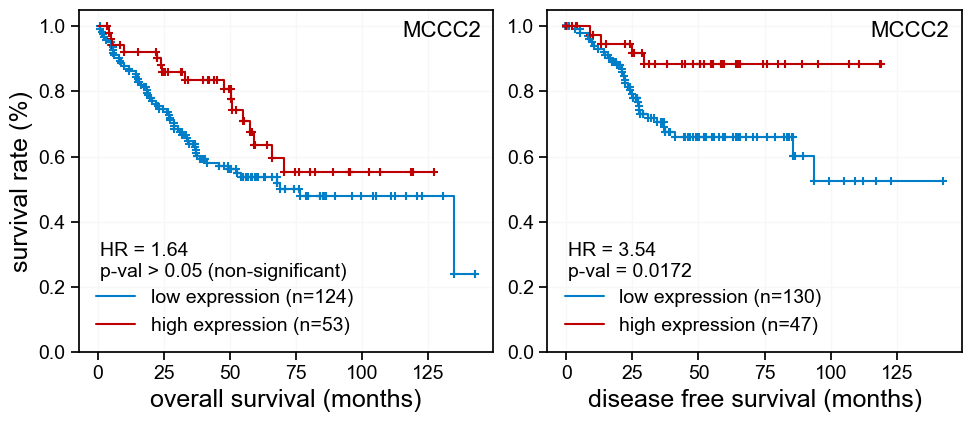

Plotting PCCA (ENSEMBL: ENSG00000175198, Probe: 203860_at_at)
Figure saved: figure2c_kmplot_gene_PCCA


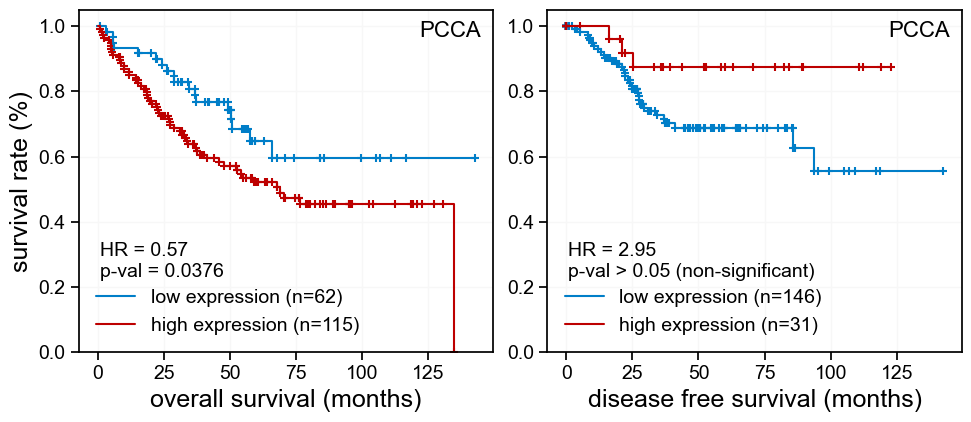

Plotting MAOB (ENSEMBL: ENSG00000069535, Probe: 204041_at_at)
Figure saved: figure2c_kmplot_gene_MAOB


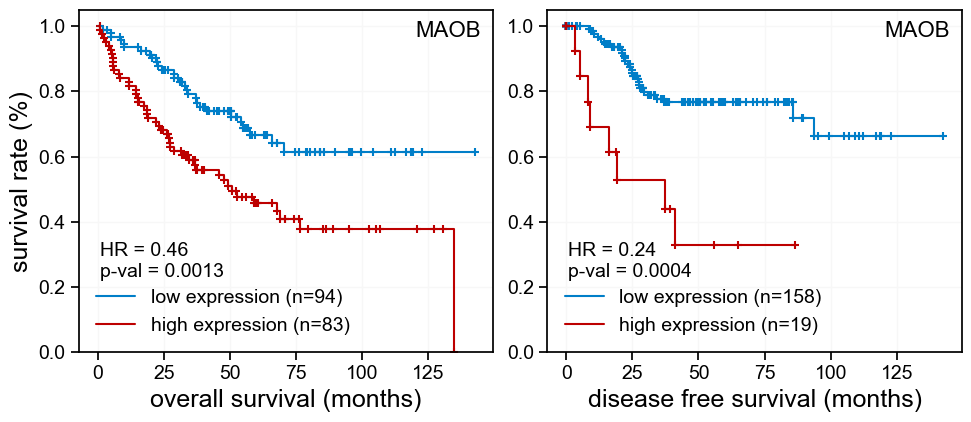

In [ ]:
def plotKMforGenes(survival_data, selected_genes=None, selected_probes=None, figsize=(10, 5)):
    
    # Filter data based on selected genes if provided
    genes_to_plot = {}
    
    if selected_genes is None:
        # Plot all genes
        genes_to_plot = survival_data
    else:
        # Convert selected_genes to a set for faster lookup
        selected_set = set(selected_genes)
        
        # Find matching genes in survival_data
        for unique_key, data in survival_data.items():
            gene_symbol = data['gene_symbol']
            probe_id = data['probe_id']
            probe_id_short = probe_id.removesuffix("_at")  # Remove '_at' suffix for matching
            
            # Check if gene symbol or probe ID matches
            if (gene_symbol in selected_set or 
                probe_id in selected_set or 
                probe_id_short in selected_set):
                genes_to_plot[unique_key] = data
        
        if len(genes_to_plot) == 0:
            print(f"Warning: None of the selected genes found in survival_data")
            print(f"Selected: {selected_genes}")
            print(f"Available genes: {[data['gene_symbol'] for data in survival_data.values()]}")
            return
    
    print(f"Plotting {len(genes_to_plot)} gene(s)")

    # Set R's default colors
    colors = {
        'high': "#BD0000",  # red for high expression
        'low': "#007EC8"    # blue for low expression
    }
    
    for unique_key, data in genes_to_plot.items():
        gene_symbol = data['gene_symbol']
        ensembl_id = data['ensembl_id']
        probe_id = data['probe_id']
        os_data = data['os_data']
        dfs_data = data['dfs_data']
        os_pval = data['os_pval']
        dfs_pval = data['dfs_pval']
        os_hr = data['os_hr']
        dfs_hr = data['dfs_hr']
        
        print(f"Plotting {gene_symbol} (ENSEMBL: {ensembl_id}, Probe: {probe_id})")
        
        # Create the figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Plot OS data
        if 'gene_expr' in os_data.columns:
            os_groups = os_data['gene_expr'].unique()
            
            for group in os_groups:
                group_data = os_data[os_data['gene_expr'] == group]
                group_data = group_data.sort_values('time')
                
                # Calculate survival curve
                times = group_data['time'].values
                events = group_data['event'].values
                n_samples = len(group_data)
                
                # Manually calculate survival curve
                surv_prob = 1.0
                n_at_risk = n_samples
                survival_times = [0]
                survival_probs = [1.0]
                
                # Track positions for marker placement
                mark_times = []
                mark_probs = []
                
                for i, t in enumerate(times):
                    if events[i] == 1:  # Event occurred
                        surv_prob *= (n_at_risk - 1) / n_at_risk
                    
                    # For both events and censored points, add a marker
                    mark_times.append(t)
                    mark_probs.append(surv_prob)
                    
                    n_at_risk -= 1
                    survival_times.append(t)
                    survival_probs.append(surv_prob)
                
                # Plot the step function
                color = colors.get(group, 'gray')
                ax1.step(survival_times, survival_probs, where='post', 
                        label=f"{group} expression (n={n_samples})", color=color)
                
                # Add '+' markers at each observation
                ax1.scatter(mark_times, mark_probs, color=color, marker='+', s=30)
        
        # Plot DFS data
        if 'gene_expr' in dfs_data.columns:
            dfs_groups = dfs_data['gene_expr'].unique()
            
            for group in dfs_groups:
                group_data = dfs_data[dfs_data['gene_expr'] == group]
                group_data = group_data.sort_values('time')
                
                # Calculate survival curve
                times = group_data['time'].values
                events = group_data['event'].values
                n_samples = len(group_data)
                
                # Manually calculate survival curve
                surv_prob = 1.0
                n_at_risk = n_samples
                survival_times = [0]
                survival_probs = [1.0]
                
                # Track positions for marker placement
                mark_times = []
                mark_probs = []
                
                for i, t in enumerate(times):
                    if events[i] == 1:  # Event occurred
                        surv_prob *= (n_at_risk - 1) / n_at_risk
                    
                    # For both events and censored points, add a marker
                    mark_times.append(t)
                    mark_probs.append(surv_prob)
                    
                    n_at_risk -= 1
                    survival_times.append(t)
                    survival_probs.append(surv_prob)
                
                # Plot the step function
                color = colors.get(group, 'gray')
                ax2.step(survival_times, survival_probs, where='post', 
                        label=f"{group} expression (n={n_samples})", color=color)
                
                # Add '+' markers at each observation
                ax2.scatter(mark_times, mark_probs, color=color, marker='+', s=30)
        
        
    
        # Add HR and p-value to OS plot
        ax1.text(0.97, 0.92, f"{gene_symbol}", transform=ax1.transAxes, fontsize=16, ha='right', color='black')
        #ax1.text(0.97, 0.87, f"{probe_id}".removesuffix("_at"), transform=ax1.transAxes, fontsize=12, ha='right', color='gray')
        if os_pval is not None:
            ax1.text(0.05, 0.28, f"HR = {os_hr:.2f}", transform=ax1.transAxes, fontsize=14)

            if os_pval > 0.05:
                ax1.text(0.05, 0.22, "p-val > 0.05 (non-significant)", transform=ax1.transAxes, fontsize=14)
            else:
                ax1.text(0.05, 0.22, f"p-val = {os_pval:.4f}", transform=ax1.transAxes, fontsize=14)
        
        ax1.set_ylabel("survival rate (%)")
        ax1.set_xlabel("overall survival (months)")
        ax1.set_ylim(0, 1.05)
        ax1.legend(loc='lower left', frameon=False, fontsize=14)
        

        # Add HR and p-value to DFS plot
        ax2.text(0.97, 0.92, f"{gene_symbol}", transform=ax2.transAxes, fontsize=16, ha='right', color='black')
        #ax2.text(0.97, 0.87, f"{probe_id}".removesuffix("_at"), transform=ax2.transAxes, fontsize=12, ha='right', color='gray')
        if dfs_pval is not None:
            ax2.text(0.05, 0.28, f"HR = {dfs_hr:.2f}", transform=ax2.transAxes, fontsize=14)
            if dfs_pval > 0.05:
                ax2.text(0.05, 0.22, "p-val > 0.05 (non-significant)", transform=ax2.transAxes, fontsize=14)
            else:
                ax2.text(0.05, 0.22, f"p-val = {dfs_pval:.4f}", transform=ax2.transAxes, fontsize=14)
        
        ax2.set_xlabel("disease free survival (months)")
        ax2.set_ylabel("")
        ax2.set_ylim(0, 1.05)
        #ax2.set_yticklabels([])  # Hide y-axis ticks for DFS plot
        ax2.legend(loc='lower left', frameon=False, fontsize=14)
        
        plt.tight_layout()
        # set wspace
        plt.subplots_adjust(wspace=0.13)
        save_figure(fig, 'figure2c_kmplot_gene_' + gene_symbol)
        plt.show()
        plt.close()


plotKMforGenes(survival_data, ['209624_s_at', '203860_at_at', '204041_at_at'], figsize=(10, 4.5))

## Figure 2: Computational gene knockout analysis identifies metabolic vulnerabilities with clinical prognostic value.

Figure saved: Figure2_Knockout_Survival


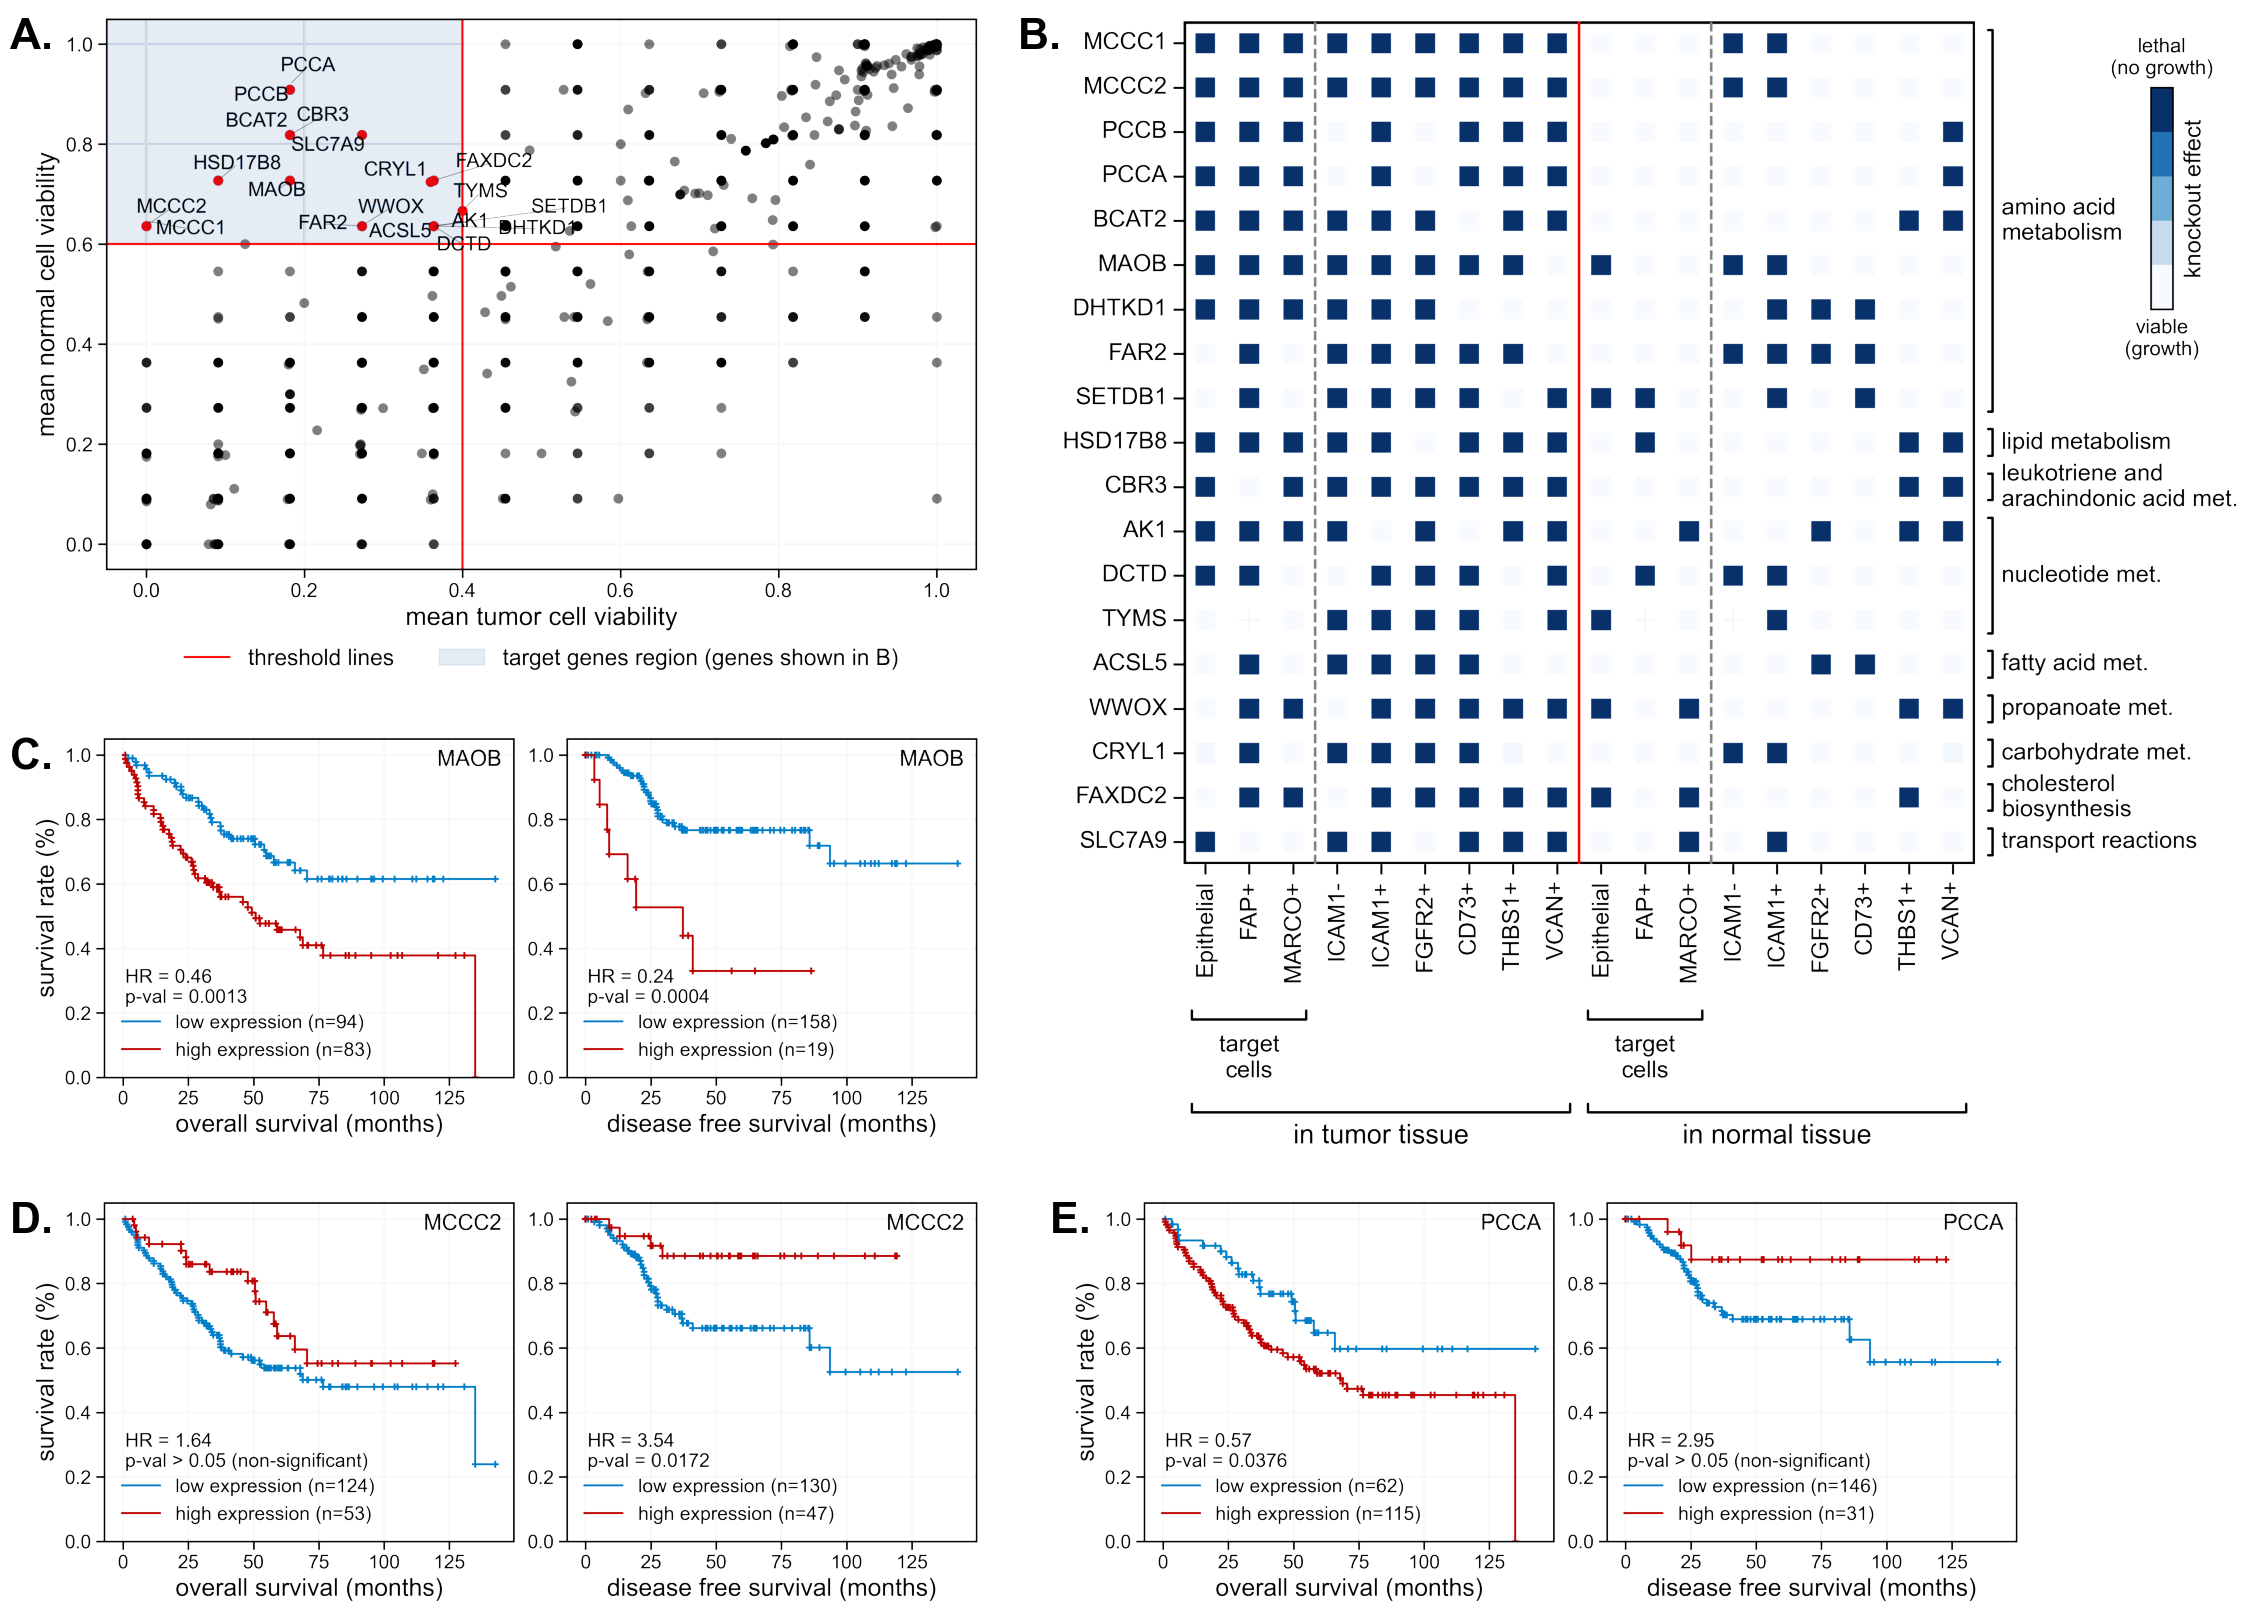

In [114]:


fig = plt.figure(figsize=(16, 16))
def add_panel(image_path, xyw, label=None, z=1):
    x, y, w = xyw
    # Read image to get aspect ratio
    img = mpimg.imread(image_path)
    img_h, img_w = img.shape[:2]
    aspect_ratio = img_h / img_w
    h = w * aspect_ratio  # scale height to keep image ratio
    bottom = 1 - y - h # Convert y from top-left origin to bottom-left origin
    ax = fig.add_axes([x, bottom, w, h], zorder=z)
    ax.imshow(img)
    ax.axis("off")
    if label:
        if label == "B": x=x-0.01
        fig.text(x-0.01, bottom + h -0.005, label +'. ', fontsize=31, ha='left', va='top', fontweight='bold')

add_panel("../figures/png/figure2a_gene_knockout_scatter.png", [0, 0, 0.6],    "A")
add_panel("../figures/png/figure2b_target_genes_heatmap.png",  [0.64, 0, 0.75],     "B")
add_panel("../figures/png/figure2c_kmplot_gene_MAOB.png",      [0, 0.45, 0.6],    "C")
add_panel("../figures/png/figure2c_kmplot_gene_MCCC2.png",     [0, 0.74, 0.6],    "D")
add_panel("../figures/png/figure2c_kmplot_gene_PCCA.png",      [0.65, 0.74, 0.6], "E")

save_figure(fig, 'Figure2_Knockout_Survival')